# Bagging/Random Forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


The classification goal is predicting if the client will subscribe to a term deposit https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification 

In [2]:
data = pd.read_csv('./data/banking_train.csv')


In [3]:
data.sample(5)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
6335,33,technician,divorced,professional.course,no,yes,yes,cellular,may,tue,668,4,999,0,nonexistent,no
7129,53,blue-collar,married,basic.4y,unknown,no,no,telephone,may,wed,559,2,999,0,nonexistent,no
29804,28,services,single,high.school,no,no,no,cellular,jul,tue,82,4,999,0,nonexistent,no
25131,65,retired,married,basic.4y,no,yes,no,cellular,aug,tue,197,2,999,1,failure,no
19610,43,blue-collar,married,basic.6y,no,no,no,cellular,may,fri,36,5,999,1,failure,no


In [4]:
# Convert yes/no to 1/0
data['y'] = pd.Series(np.where(data['y'].values == 'yes', 1, 0))
data['y'].value_counts()


0    29238
1     3712
Name: y, dtype: int64

Dataset is not too large and unbalanced, so we can use Stratified K-fold Cross-validation. 

There is no test dataset, so create it separating 20% from the dataset to run the model only once to find out the final result. 

Use the `roc_auc` metric because we need to identify the most promising clients for working with them.

In [8]:
def get_train_test(df):
    X, y = df.drop('y', axis = 1), df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test


In [5]:
def train_scoring(model, X_train_transform, y_train):
    cv_score = np.mean(cross_val_score(model, X_train_transform, y_train.values, cv=3, scoring='roc_auc'))
    return cv_score


In [6]:
def visual_result(model, X_train_transform, y_train, X_test_transform, y_test):
    print(f"roc_auc_score on cross-validation: {np.mean(cross_val_score(model, X_train_transform, y_train.values, cv=3, scoring='roc_auc')):.4f}")
    model.fit(X_train_transform, y_train.values)
    predict = model.predict(X_test_transform)
    print(f"roc_aus_score on test: {roc_auc_score(y_test, model.predict_proba(X_test_transform)[:, 1]):.4f}")
    print(classification_report(y_test, predict))
    plt.rcParams['figure.figsize'] = 7, 5
    cm = confusion_matrix(y_test, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap=plt.cm.plasma);
    plt.show()


In [9]:
X_train, X_test, y_train, y_test = get_train_test(data)
X_train.shape, X_test.shape


((26360, 15), (6590, 15))

In [10]:
print(f"y_train:\n {y_train.value_counts(normalize=True)}")
print(f"y_test:\n {y_test.value_counts(normalize=True)}")


y_train:
 0    0.887329
1    0.112671
Name: y, dtype: float64
y_test:
 0    0.887405
1    0.112595
Name: y, dtype: float64


Encoding the categorical data


In [11]:
label_enc_col = ['job', 'education', 'contact', 'month', 'day_of_week']
one_hot_enc_col = ['marital', 'default', 'housing', 'loan', 'poutcome']

transformer = make_column_transformer(
    (OneHotEncoder(), one_hot_enc_col),
    (OrdinalEncoder(), label_enc_col),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_train_transform = transformer.fit_transform(X_train)
X_test_transform = transformer.transform(X_test)
print(f'X_train_transform: {X_train_transform.shape}, X_test_transform: {X_test_transform.shape}')


X_train_transform: (26360, 26), X_test_transform: (6590, 26)


In [12]:
class CustomBaggingClassifier(BaseEstimator):
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 max_samples=1.0,
                 max_features=1.0,
                 random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.random_state = random_state
        self.models = []
        self.classes_ = np.array([0, 1])

    def get_samples(self, X, y):
        # function to generate subsample
        if isinstance(self.max_samples, float):
            self.max_samples = int(X.shape[0]*self.max_samples)
        if isinstance(self.max_features, float):
            self.max_features = int(X.shape[1]*self.max_features)
        idx_row = np.random.choice(X.shape[0], (self.max_samples))
        idx_column = np.random.choice(X.shape[1], (self.max_features))
        X_sample = X[np.ix_(idx_row, idx_column)]
        y_sample = y[idx_row]
        return X_sample, y_sample, idx_column


    def fit(self, X, y):

        self.models = []
        # divide train data on n parts (n_estimators)
        np.random.seed(self.random_state)
        for i in range(self.n_estimators):
            X_sample, y_sample, idx_column = self.get_samples(X, y)
            model = deepcopy(self.base_estimator)
            model.fit(X_sample, y_sample)
            self.models.append([model, idx_column])

    def predict_proba(self, X):
        results = []
        for model in self.models:
            result = model[0].predict_proba(X[:, model[1]])
            results.append(result)
        return np.mean(results, axis=0)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Compare performance of sklearn bagging model with my own implementation

1. My own implementation

In [14]:
model_cbc = CustomBaggingClassifier(
    DecisionTreeClassifier(max_depth=7, random_state=24),
    n_estimators=100, max_samples=0.7, max_features=0.7, random_state=24
)

train_scoring(model_cbc, X_train_transform, y_train)


0.9188030107249411

2. Sklearn implementation

In [16]:
model_sklearn = BaggingClassifier(
    DecisionTreeClassifier(max_depth=7, random_state=24),
    n_estimators=100, max_samples=0.7, max_features=0.7, random_state=24
)

train_scoring(model_sklearn, X_train_transform, y_train)


0.9177905352878369

Very similar results were obtained

Let's try to choose better parametres for CustomBaggingClassifier.

In [18]:
parameters_grid = {
    "base_estimator__max_depth": [3, 5, 7, 10, 15],
    "base_estimator__min_samples_leaf": [1, 3, 5, 7],
    "max_samples": [0.6, 0.7, 0.8, 0.9],
    "max_features": [0.6, 0.7, 0.8, 0.9]
}

model_cbc = CustomBaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    random_state=42, n_estimators=200
)

gcv = RandomizedSearchCV(model_cbc, parameters_grid, n_iter=30,
                         scoring="roc_auc", cv=3, n_jobs=-1, verbose=1,
                         random_state=42)
gcv.fit(X_train_transform, y_train.values)
print(gcv.best_score_, gcv.best_estimator_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
0.9202531292639745 CustomBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                              max_depth=10,
                                                              min_samples_leaf=7,
                                                              random_state=42),
                        max_features=18, max_samples=15816, n_estimators=200,
                        random_state=42)


roc_auc_score on cross-validation: 0.9203
roc_aus_score on test: 0.9203
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      5848
           1       0.46      0.78      0.58       742

    accuracy                           0.87      6590
   macro avg       0.72      0.83      0.75      6590
weighted avg       0.91      0.87      0.89      6590



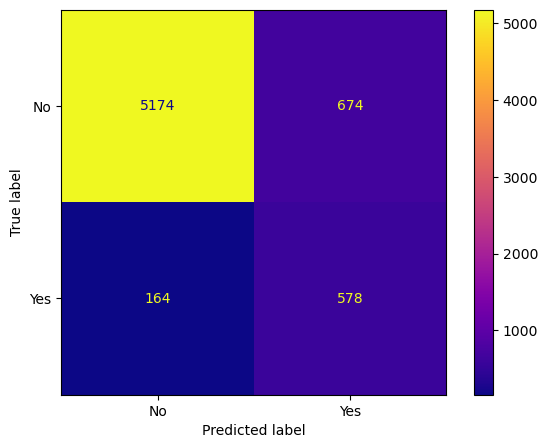

In [25]:
model_cbc = CustomBaggingClassifier(DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=10,
                                                           min_samples_leaf=7,
                                                           random_state=42),
                                    max_features=0.7, max_samples=0.6, n_estimators=200,
                                    random_state=42)
visual_result(model_cbc, X_train_transform, y_train, X_test_transform, y_test)


Let's try to choose better parameters for sklearn realisation of BaggingClassifier

In [22]:
parameters_grid = {
    "estimator__max_depth": [3, 5, 7, 10, 15],
    "estimator__min_samples_leaf": [1, 3, 5, 7],
    "max_samples": [0.6, 0.7, 0.8, 0.9],
    "max_features": [0.6, 0.7, 0.8, 0.9]
}

model_bc = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    n_estimators=200, random_state=42
)

gcv = RandomizedSearchCV(model_bc, parameters_grid, n_iter=30,
                         scoring="roc_auc", cv=3, n_jobs=-1,
                         verbose=1, random_state=42)
gcv.fit(X_train_transform, y_train)
print(gcv.best_score_, gcv.best_estimator_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
0.9248873948322478 BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=15,
                                                   min_samples_leaf=5,
                                                   random_state=42),
                  max_features=0.8, max_samples=0.7, n_estimators=200,
                  random_state=42)


roc_auc_score on cross-validation: 0.9249
roc_aus_score on test: 0.9241
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5848
           1       0.52      0.72      0.60       742

    accuracy                           0.89      6590
   macro avg       0.74      0.82      0.77      6590
weighted avg       0.91      0.89      0.90      6590



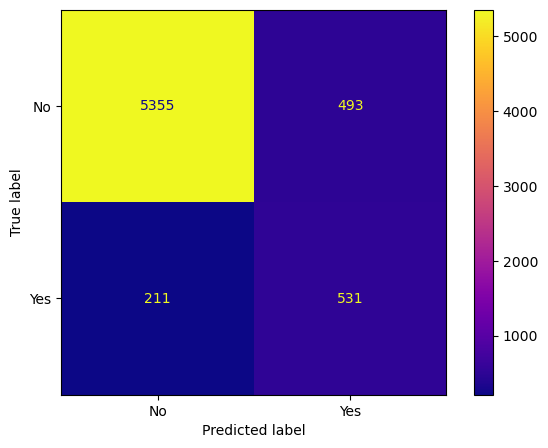

In [24]:
model_bc = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=15,
                                                    min_samples_leaf=5,
                                                    random_state=42),
                             max_features=0.8, max_samples=0.7, n_estimators=200,
                             random_state=42)
visual_result(model_bc, X_train_transform, y_train, X_test_transform, y_test)


### RandomForest

In [27]:
model_rf = RandomForestClassifier(random_state=42)
train_scoring(model_rf, X_train_transform, y_train)


0.9150029277243247

Base RandomForest is better then Bagging with DecisionTree

Let's try to choose better parameters for RandomForestClassifier with GridSearch

In [29]:
parameters_grid = {
    "max_depth": [3, 5, 7, 10, 15, 20, 25],
    "min_samples_leaf": [3, 5, 7, 10, 13, 16, 19, 22, 25],
    "max_features": [0.6, 0.7, 0.8, 0.9],
}

model = RandomForestClassifier(class_weight='balanced', n_estimators=200,
                               random_state=42, n_jobs=-1)

gcv = RandomizedSearchCV(model, parameters_grid, n_iter=100, n_jobs=-1, cv=3,
                         verbose=1, scoring='roc_auc', random_state=42)
gcv.fit(X_train_transform, y_train)
print(gcv.best_score_, gcv.best_estimator_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
0.9254756786695091 RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.6,
                       min_samples_leaf=10, n_estimators=200, n_jobs=-1,
                       random_state=42)


roc_auc_score on cross-validation: 0.9255
roc_aus_score on test: 0.9250
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      5848
           1       0.46      0.81      0.59       742

    accuracy                           0.87      6590
   macro avg       0.72      0.85      0.76      6590
weighted avg       0.92      0.87      0.89      6590



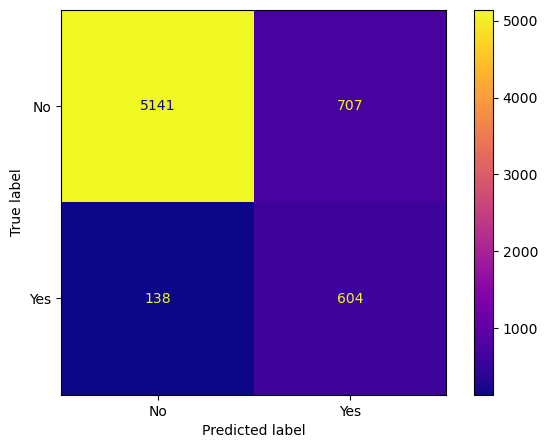

In [30]:
model_rf = RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features=0.6, min_samples_leaf=10, n_estimators=200,
                       n_jobs=-1, random_state=42)
visual_result(model_rf, X_train_transform, y_train, X_test_transform, y_test)


**CustomBaggingClassifier**:
- roc_aus_score on crossvalidation 0.9203
- roc_aus_score on test: 0.9203

**BaggingClassifier**: 
- roc_aus_score on crossvalidation 0.9249
- roc_aus_score on test: 0.9241

**RandomForestClassifier**:
- roc_aus_score on crossvalidation 0.9255
- roc_aus_score on test: 0.9250

